In [1]:
# lauch on google colab
import os
from google.colab import drive
drive.mount('/content/drive')
# just in case if you need my account
# My_id = xinggggggg@gmail.com
# My_password = xx199881

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Trying to make the Individual_Component file folder
path = "/content/drive/My Drive"
os.listdir(path)
os.makedirs('/content/drive/My Drive/Individual_Component')

In [0]:
# Trying to extract the zip file in google drive
import zipfile
zFile = zipfile.ZipFile("/content/drive/My Drive/Individual_Component.zip", "r")
for fileM in zFile.namelist(): 
    zFile.extract(fileM, "/content/drive/My Drive/Individual_Component")
zFile.close()

In [0]:
# get the files in test
path = "/content/drive/My Drive/Individual_Component/Individual_Component/test"
os.listdir(path)

In [6]:
# I reinstall the open-cv since KAZE algorhitm will perform better in 3.4.2.16
!pip uninstall opencv-python -y
!pip install opencv-python==3.4.2.16 --force-reinstall

!pip uninstall opencv-contrib-python -y
!pip install opencv-contrib-python==3.4.2.16 --force-reinstall

['test_negative', 'test_positive']

In [0]:
import cv2
import imageio
import os

In [0]:
# for KAZE 
def extract_features(image_path, vector_size=32):
    image = imageio.imread(image_path)
    try:
        # Using KAZE agorithm
        alg = cv2.KAZE_create()
        # Finding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them.
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in a big vector
        dsc = dsc.flatten()
        # Making descriptor of same size = 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if less 32 descriptors then adding zeros at the end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except:
        print('Error: ')
        return None
    return dsc

In [0]:
# For SIFT
def extract_features2(image_path, vector_size=32):
    img = imageio.imread(image_path)
    try:
        # gray scale the image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # using the SIFT
        sift = cv2.xfeatures2d.SIFT_create()
        # detect the img
        kp = sift.detect(gray, None)
        dsc = sift.compute(gray, kp)
        dsc = dsc[1]
        dsc = dsc.flatten()
        needed_size = (vector_size * 64)
        # finalizing
        if dsc.size > needed_size:
          dsc = dsc[:needed_size]
        if dsc.size < needed_size:
            # if less 32 descriptors then adding zeros at the end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except:
        print('Error: ')
        return None
    return dsc

In [0]:
# for training and testing 'get all files in a path'
def getallfile(path):
    allfilelist = os.listdir(path)
    for file in allfilelist:
        filepath = os.path.join(path, file)
        if os.path.isdir(filepath):
            getallfile(filepath)
        elif os.path.isfile(filepath):
            allpath.append(filepath)
    return allpath

In [0]:
# extract image feature
def batch_extractor(images_path, feat_save_path):
    sm_file = open(feat_save_path, 'wt', encoding='utf-8')
    files_list = getallfile(images_path)
    for f in files_list:
        print('Extracting features from image %s' % f)
        value_list = extract_features(f)
        if value_list is not None:
            sm_file.write(','.join(map(lambda x: str(x), value_list)) + '\n')
    sm_file.close()

In [0]:
def batch_extractor2(images_path, feat_save_path):
    sm_file = open(feat_save_path, 'wt', encoding='utf-8')
    files_list = getallfile(images_path)
    for f in files_list:
        print('Extracting features from image %s' % f)
        value_list = extract_features2(f)
        if value_list is not None:
            sm_file.write(','.join(map(lambda x: str(x), value_list)) + '\n')
    sm_file.close()

In [0]:
# extract files
allpath = []
batch_extractor('/content/drive/My Drive/Individual_Component/Individual_Component/train/train_positive', '/content/drive/My Drive/Individual_Component/tp.txt')
print(os.path.getsize('/content/drive/My Drive/Individual_Component/tp.txt'))

allpath = []
batch_extractor('/content/drive/My Drive/Individual_Component/Individual_Component/train/train_negative_A', '/content/drive/My Drive/Individual_Component/tn.txt')
print(os.path.getsize('/content/drive/My Drive/Individual_Component/tn.txt'))

allpath = []
batch_extractor('/content/drive/My Drive/Individual_Component/Individual_Component/test/test_positive', '/content/drive/My Drive/Individual_Component/testp.txt')

allpath = []
batch_extractor('/content/drive/My Drive/Individual_Component/Individual_Component/test/test_negative', '/content/drive/My Drive/Individual_Component/testn.txt')

In [0]:
import cv2
import imageio
import os
import numpy as np
allpath = []
batch_extractor2('/content/drive/My Drive/Individual_Component/Individual_Component/train/train_positive', '/content/drive/My Drive/Individual_Component/tp2.txt')
allpath = []
batch_extractor2('/content/drive/My Drive/Individual_Component/Individual_Component/train/train_negative_A', '/content/drive/My Drive/Individual_Component/tn2.txt')

In [0]:
import numpy as np
import pandas as pd
import datetime
from scipy.stats import ks_2samp
import xgboost as xgb
import json
import math
import pickle
import re

# read text file which store the feature
tp = pd.read_csv('/content/drive/My Drive/Individual_Component/tp.txt', header=None,error_bad_lines=False)
tp['tag'] = 1
tn = pd.read_csv('/content/drive/My Drive/Individual_Component/tn.txt', header=None,error_bad_lines=False)
tn['tag'] = 0
#put in a frame
frames = [tp, tn]
df = pd.concat(frames)
df = df.sample(frac=1, random_state=datetime.datetime.now().microsecond)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

print(df.shape)

# read text file which test positive and negative
testp = pd.read_csv('/content/drive/My Drive/Individual_Component/testp.txt', header=None,error_bad_lines=False)
testp['tag'] = 1
testn = pd.read_csv('/content/drive/My Drive/Individual_Component/testn.txt', header=None,error_bad_lines=False)
testn['tag'] = 0
# put in a frame
frames = [testp, testn]
df_test = pd.concat(frames)
df_test = df_test.sample(frac=1, random_state=datetime.datetime.now().microsecond)
df_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_test.columns.values]

print(df_test.shape)


In [0]:
# label_col = df['tag']
# cut = round(0.8 * df.shape[0])
train_df = df
test_df = df_test
y_train = train_df['tag']
X_train = train_df.drop(['tag'], axis=1)
y_test = test_df['tag']
X_test = test_df.drop(['tag'], axis=1)

# reimport XGB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot


# init XGB with small defalut value
model = XGBClassifier(learning_rate=0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
scale_pos_weight=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
# fitting training data
model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()



In [0]:
# label_col = df['tag']
# cut = round(0.8 * df.shape[0])
train_df = df
test_df = df_test

y_train = train_df['tag']
X_train = train_df.drop(['tag'], axis=1)

y_test = test_df['tag']
X_test = test_df.drop(['tag'], axis=1)

# import some additional packages
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

#initialize XGB classifier
model = XGBClassifier(learning_rate=0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
scale_pos_weight=1)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

[0]	validation_0-error:0.232458	validation_0-logloss:0.662967	validation_1-error:0.200794	validation_1-logloss:0.659794
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-error:0.232458	validation_0-logloss:0.638376	validation_1-error:0.200794	validation_1-logloss:0.632183
[2]	validation_0-error:0.232458	validation_0-logloss:0.618162	validation_1-error:0.200794	validation_1-logloss:0.609828
[3]	validation_0-error:0.232458	validation_0-logloss:0.601158	validation_1-error:0.200794	validation_1-logloss:0.590431
[4]	validation_0-error:0.232458	validation_0-logloss:0.586832	validation_1-error:0.200794	validation_1-logloss:0.574498
[5]	validation_0-error:0.232458	validation_0-logloss:0.574487	validation_1-error:0.200794	validation_1-logloss:0.560144
[6]	validation_0-error:0.232458	validation_0-logloss:0.56383	validation_1-error:0.200794	validation_1-logloss:0.548

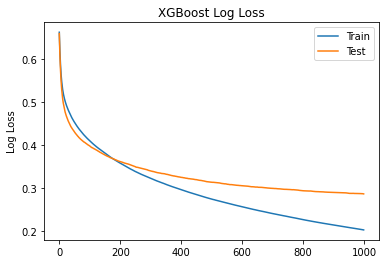

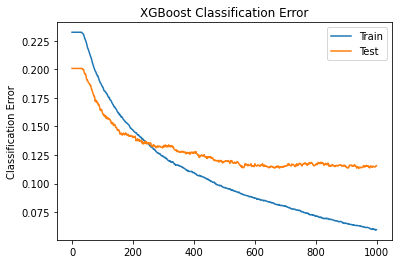